# Laboratorio 8 Data Science
## Detección de Anomalías con Autoencoder, Isolation Forest y LOF

Autores:

- Nelson García Bravatti
- Christian Echeverría

# 1. Carga del Conjunto de Datos:

In [1]:
import pandas as pd
from sklearn.datasets import fetch_covtype
from sklearn.preprocessing import StandardScaler

# Cargar dataset
data = fetch_covtype(as_frame=True)
df = data.frame

# Separar características y target
X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type']

# Identificar columnas numéricas y binarias
numeric_cols = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
                'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
                'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
                'Horizontal_Distance_To_Fire_Points']

binary_cols = [col for col in X.columns if col not in numeric_cols]

# Escalar solo numéricas
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# 2. Etiquetado de Normal/Anómalo

In [2]:
# Crear etiqueta binaria: 0 = normal (Lodgepole Pine), 1 = anomalía
y_bin = (y != 2).astype(int)  # 0 si es 2, 1 si es otro

# 3. División de Datos

In [3]:
from sklearn.model_selection import train_test_split

# Filtrar solo normales para train/val
X_normal = X_scaled[y_bin == 0]
y_normal = y_bin[y_bin == 0]

# División interna: train + val (solo normales)
X_train, X_val, _, _ = train_test_split(
    X_normal, y_normal, test_size=0.2, random_state=42, stratify=None
)

# Test: normales + anómalos
X_test = X_scaled
y_test = y_bin

# 4. Entrenado de modelos

### Autoencoder

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Arquitectura simétrica
input_dim = X_train.shape[1]
encoding_dim = 8

input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(input_layer)
encoded = Dense(16, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)

decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Entrenar solo con normales
autoencoder.fit(X_train, X_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(X_val, X_val),
                verbose=0)

### Isolation Forest

In [5]:
from sklearn.ensemble import IsolationForest

# Entrenar solo con normales
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(X_train)

IsolationForest(contamination=0.05, random_state=42)

### LOF


In [6]:
from sklearn.neighbors import LocalOutlierFactor

# Entrenar solo con normales (novelty=True)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05, novelty=True)
lof.fit(X_train)

LocalOutlierFactor(contamination=0.05, novelty=True)

# 5. Evaluación de modelos


In [7]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score

# ---------- 1. Autoencoder ----------
# Reconstrucción y error
X_test_pred = autoencoder.predict(X_test, verbose=0)
mse = ((X_test - X_test_pred) ** 2).mean(axis=1)
# Umbral rápido: percentil 95 del error en validación
threshold_ae = mse[y_bin == 0].quantile(0.95)
y_pred_ae = (mse > threshold_ae).astype(int)

# ---------- 2. Isolation Forest ----------
y_pred_iso = (iso_forest.predict(X_test) == -1).astype(int)  # -1 = anomalía

# ---------- 3. LOF ----------
y_pred_lof = (lof.predict(X_test) == -1).astype(int)  # -1 = anomalía

# ---------- Métricas ----------
models = {
    'Autoencoder': (y_test, y_pred_ae),
    'IsolationForest': (y_test, y_pred_iso),
    'LOF': (y_test, y_pred_lof)
}

for name, (y_true, y_pred) in models.items():
    print(f"\n{name}")
    print(f"  ROC-AUC : {roc_auc_score(y_true, y_pred):.3f}")
    print(f"  PR-AUC  : {average_precision_score(y_true, y_pred):.3f}")
    print(f"  F1      : {f1_score(y_true, y_pred):.3f}")
    print(f"  Prec    : {precision_score(y_true, y_pred):.3f}")
    print(f"  Recall  : {recall_score(y_true, y_pred):.3f}")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(



Autoencoder
  ROC-AUC : 0.596
  PR-AUC  : 0.590
  F1      : 0.375
  Prec    : 0.835
  Recall  : 0.242

IsolationForest
  ROC-AUC : 0.547
  PR-AUC  : 0.547
  F1      : 0.243
  Prec    : 0.753
  Recall  : 0.145

LOF
  ROC-AUC : 0.793
  PR-AUC  : 0.780
  F1      : 0.754
  Prec    : 0.937
  Recall  : 0.630


In [8]:

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay,
    f1_score, precision_score, recall_score
)

# -------------------------------------------------------
# Utilidades para obtener "scores de anomalía" (alto = malo)
# -------------------------------------------------------
def ensure_numpy(x):
    return np.asarray(x).ravel()

def anomaly_scores_autoencoder(model, X, batch_size=1024):
    """Score = MSE de reconstrucción (↑ = más anómalo)."""
    Xhat = model.predict(X, batch_size=batch_size, verbose=0)
    return np.mean((X - Xhat)**2, axis=1)

def anomaly_scores_isoforest(model, X):
    """
    IsolationForest: decision_function/score_samples ↑ = más normal.
    Invertimos para que ↑ = más anómalo.
    """
    if hasattr(model, "decision_function"):
        s = model.decision_function(X)
    else:
        s = model.score_samples(X)
    return -ensure_numpy(s)

def anomaly_scores_lof(model, X):
    """
    LOF con novelty=True: decision_function/score_samples ↑ = más normal.
    Invertimos para que ↑ = más anómalo.
    """
    if hasattr(model, "decision_function"):
        s = model.decision_function(X)
    elif hasattr(model, "score_samples"):
        s = model.score_samples(X)
    else:
        raise ValueError(
            "LOF debe crearse con novelty=True para evaluar en test. "
            "Usa LocalOutlierFactor(novelty=True, ...)."
        )
    return -ensure_numpy(s)

def minmax(x):
    x = ensure_numpy(x)
    m, M = np.min(x), np.max(x)
    return (x - m) / (M - m + 1e-12)

# -------------------------------------------------------
# Métricas a partir de scores (y_test: 1=anómalo, 0=normal)
# -------------------------------------------------------
def metrics_from_scores(y_true, scores):
    y_true = ensure_numpy(y_true)
    scores = ensure_numpy(scores)
    roc_auc = roc_auc_score(y_true, scores)
    fpr, tpr, roc_th = roc_curve(y_true, scores)
    precision, recall, pr_th = precision_recall_curve(y_true, scores)
    ap = average_precision_score(y_true, scores)  # PR-AUC
    return {
        "roc_auc": roc_auc, "fpr": fpr, "tpr": tpr, "roc_th": roc_th,
        "precision": precision, "recall": recall, "pr_th": pr_th, "ap": ap
    }

def best_f1_threshold(y_true, scores, grid_size=200):
    """
    Busca el umbral que maximiza F1 explorando cuantiles del score.
    Devuelve umbral, F1, Precisión y Recall.
    """
    y_true = ensure_numpy(y_true)
    scores = ensure_numpy(scores)
    qs = np.linspace(0.0, 1.0, grid_size+2)[1:-1]
    thr_grid = np.quantile(scores, qs)
    best = {"threshold": None, "f1": -1.0, "precision": None, "recall": None}
    for tau in np.unique(thr_grid):
        y_pred = (scores >= tau).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best["f1"]:
            best.update({
                "threshold": float(tau),
                "f1": float(f1),
                "precision": float(precision_score(y_true, y_pred, zero_division=0)),
                "recall": float(recall_score(y_true, y_pred, zero_division=0)),
            })
    return best

def precision_at_k(y_true, scores, k):
    """
    Precision@k: si k es float (0<k<=1) toma el top-k% por score.
    Si k es int, toma el top-k elementos.
    """
    y_true = ensure_numpy(y_true)
    scores = ensure_numpy(scores)
    n = len(scores)
    if isinstance(k, float):
        k = int(np.ceil(k * n))
    k = max(1, min(n, int(k)))
    idx = np.argsort(-scores)[:k]
    return float(np.mean(y_true[idx] == 1))


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Resumen AUCs (ordenado por PR-AUC):


,ROC-AUC,PR-AUC (AP)
LOF,0.9027,0.9179


Mejor modelo por PR-AUC: LOF (AP=0.9179)
[LOF] Mejor F1: 0.8267 @ umbral=0.020288 | Prec=0.8112 | Rec=0.8428
LOF | Precision@1%: 0.9995
LOF | Precision@5%: 0.9977
LOF | Precision@100: 1.0000
LOF | Precision@500: 0.9980


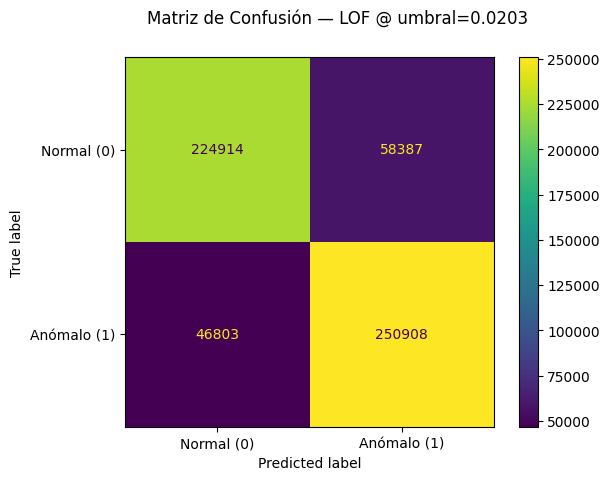

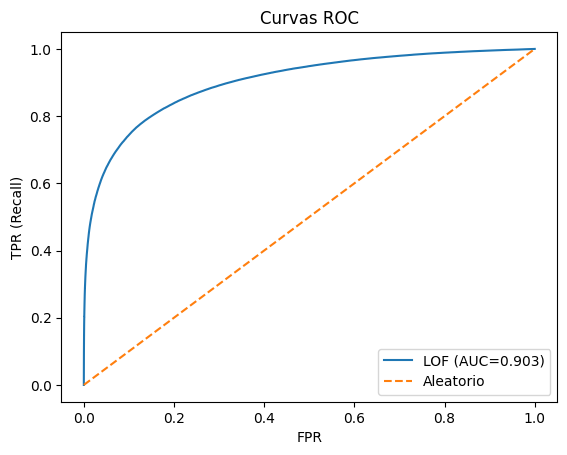

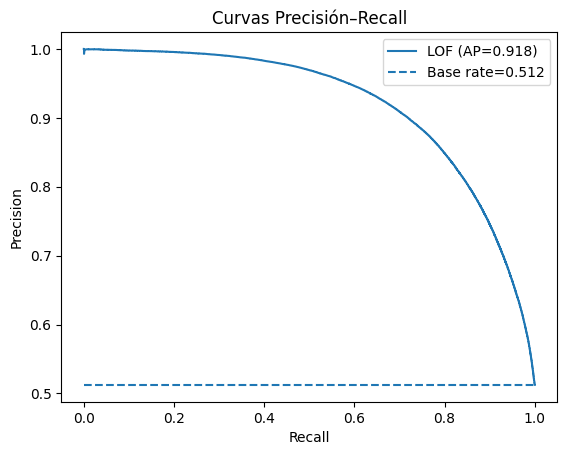

In [9]:
# -------------------------------------------------------
# 1) Crear scores de cada modelo (alto = más anómalo)
# -------------------------------------------------------
scores = {}

if 'scores_autoencoder' in globals(): scores['Autoencoder'] = ensure_numpy(scores_autoencoder)
if 'scores_iso'         in globals(): scores['Isolation Forest'] = ensure_numpy(scores_iso)
if 'scores_lof'         in globals(): scores['LOF'] = ensure_numpy(scores_lof)

# Si tienes los modelos, se calculan los scores:
if 'ae_model' in globals() and 'Autoencoder' not in scores:
    scores['Autoencoder'] = anomaly_scores_autoencoder(ae_model, X_test)
if 'iso' in globals() and 'Isolation Forest' not in scores:
    scores['Isolation Forest'] = anomaly_scores_isoforest(iso, X_test)
if 'lof' in globals() and 'LOF' not in scores:
    scores['LOF'] = anomaly_scores_lof(lof, X_test)

if not scores:
    raise RuntimeError(
        "No se encontraron modelos ni vectores de score. "
        "Provee (ae_model/iso/lof) o (scores_autoencoder/scores_iso/scores_lof)."
    )

# Normalizar a [0,1] para comparabilidad visual
scores_mm = {name: minmax(s) for name, s in scores.items()}

# -------------------------------------------------------
# 2) Métricas globales (ROC-AUC, PR-AUC) y curvas
# -------------------------------------------------------
res = {name: metrics_from_scores(y_test, s) for name, s in scores_mm.items()}

summary = pd.DataFrame(
    {name: {"ROC-AUC": r["roc_auc"], "PR-AUC (AP)": r["ap"]} for name, r in res.items()}
).T.sort_values("PR-AUC (AP)", ascending=False)

print("Resumen AUCs (ordenado por PR-AUC):")
display(summary.style.format("{:.4f}"))

# -------------------------------------------------------
# 3) Elegir "mejor modelo" por PR-AUC (AP)
#    (PR-AUC es más informativa en escenarios desbalanceados)
# -------------------------------------------------------
best_model = summary.index[0]
best_scores = scores_mm[best_model]
print(f"Mejor modelo por PR-AUC: {best_model} (AP={summary.loc[best_model, 'PR-AUC (AP)']:.4f})")

# -------------------------------------------------------
# 4) F1@umbral -> selecciona umbral que maximiza F1
#    (Si ya tienes un umbral elegido con validación, úsalo)
# -------------------------------------------------------
best = best_f1_threshold(y_test, best_scores)
tau = best["threshold"]
print(f"[{best_model}] Mejor F1: {best['f1']:.4f} @ umbral={tau:.6f} | "
      f"Prec={best['precision']:.4f} | Rec={best['recall']:.4f}")

# -------------------------------------------------------
# 5) Matriz de Confusión del mejor modelo usando ese umbral
# -------------------------------------------------------
y_pred_best = (best_scores >= tau).astype(int)
cm = confusion_matrix(y_test, y_pred_best, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal (0)", "Anómalo (1)"])
fig = disp.plot(values_format="d").figure_
fig.suptitle(f"Matriz de Confusión — {best_model} @ umbral={tau:.4f}")

# -------------------------------------------------------
# 6) Curvas ROC (todas) con AUC
# -------------------------------------------------------
plt.figure()
for name, r in res.items():
    plt.plot(r["fpr"], r["tpr"], label=f"{name} (AUC={r['roc_auc']:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Aleatorio")
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
plt.title("Curvas ROC")
plt.legend()

# -------------------------------------------------------
# 7) Curvas Precisión–Recall (todas) con PR-AUC (AP)
#    Incluye tasa base de anomalías como referencia
# -------------------------------------------------------
plt.figure()
base_rate = float(np.mean(ensure_numpy(y_test) == 1))
for name, r in res.items():
    plt.plot(r["recall"], r["precision"], label=f"{name} (AP={r['ap']:.3f})")
plt.hlines(base_rate, xmin=0, xmax=1, linestyles="--", label=f"Base rate={base_rate:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curvas Precisión–Recall")
plt.legend()

# -------------------------------------------------------
# 8) Precision@k para el mejor modelo (k% y k absoluto)
#    Ajusta k según tus necesidades/entorno
# -------------------------------------------------------
for k in [0.01, 0.05, 100, 500]:  # 1%, 5%, top-100, top-500
    prec_k = precision_at_k(y_test, best_scores, k)
    k_str = f"{int(k*100)}%" if isinstance(k, float) and (0 < k <= 1) else f"{k}"
    print(f"{best_model} | Precision@{k_str}: {prec_k:.4f}")


# 6. Informe corto